# Modeling Credit Risk with Lending Club data

#### Objective: Predict delinquency of a borrower
#### Metric: ROCAUC or PRAUC


The biggest question re this data is which features are pulled at origination time.
For the details on this, see stuff below:
- https://www.kaggle.com/datasets/wordsforthewise/lending-club/discussion/220358
- https://www.kaggle.com/code/tysonpo/columns-available-at-origination-answer/notebook

From those links above, it seems that most features are pulled at loan application/origination. 
The only features, pulled later, belong to the two groups:
- features, related to loan performance/payments.
- features, which clearly mention this in name/description. E.g., word 'last' in feature name.

In [52]:
#pip install openpyxl

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
import os, time, warnings, gzip, gc, random, math, shap, pickle, optuna, csv, sys
from IPython.display import display
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, KFold
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, precision_recall_curve, auc
from sklearn.metrics import mean_squared_error, mean_absolute_error, roc_auc_score
from sklearn.inspection import permutation_importance
from category_encoders import MEstimateEncoder
from xgboost import XGBClassifier

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 400)

warnings.filterwarnings("ignore")

In [54]:
### target encoding ###
# source: https://www.kaggle.com/code/ryanholbrook/feature-engineering-for-house-prices/notebook

class CrossFoldEncoder:
    def __init__(self, encoder, **kwargs):
        self.encoder_ = encoder
        self.kwargs_ = kwargs  # keyword arguments for the encoder
        self.cv_ = KFold(n_splits=4)

    # Fit an encoder on one split and transform the feature on the
    # other. Iterating over the splits in all folds gives a complete
    # transformation. We also now have one trained encoder on each
    # fold.
    def fit_transform(self, X, y, cols):
        self.fitted_encoders_ = []
        self.cols_ = cols
        X_encoded = []
        for idx_encode, idx_train in self.cv_.split(X):
            fitted_encoder = self.encoder_(cols=cols, **self.kwargs_)
            fitted_encoder.fit(
                X.iloc[idx_encode, :], y.iloc[idx_encode],
            )
            X_encoded.append(fitted_encoder.transform(X.iloc[idx_train, :])[cols])
            self.fitted_encoders_.append(fitted_encoder)
        X_encoded = pd.concat(X_encoded)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

    # To transform the test data, average the encodings learned from
    # each fold.
    def transform(self, X):
        from functools import reduce

        X_encoded_list = []
        for fitted_encoder in self.fitted_encoders_:
            X_encoded = fitted_encoder.transform(X)
            X_encoded_list.append(X_encoded[self.cols_])
        X_encoded = reduce(
            lambda x, y: x.add(y, fill_value=0), X_encoded_list
        ) / len(X_encoded_list)
        X_encoded.columns = [name + "_encoded" for name in X_encoded.columns]
        return X_encoded

In [55]:
time0 = time.time()

with open('../input/lc-800k-sample/LCLoans_141_800k.pkl', 'rb') as pickled_one:
    df = pickle.load(pickled_one)
    
display(df.head())

features_tokeep = ['loan_status',
 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment','issue_d',
 'purpose', 'title', 'initial_list_status', 'application_type',
 'grade', 'sub_grade', 'fico_range_high',
 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'zip_code', 'addr_state',
 'dti',           
 'verification_status',
 'mo_sin_rcnt_tl', 'mths_since_last_delinq', 'mths_since_last_major_derog', 'mths_since_last_record',
 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m', 
 'earliest_cr_line', 'inq_last_6mths', 'inq_fi', 'inq_last_12m',
 'open_acc', 'acc_open_past_24mths', 'mort_acc', 'total_acc',
 'avg_cur_bal', 'il_util', 'tot_cur_bal', 
 'revol_bal', 'revol_util', 'max_bal_bc',                 
 'delinq_2yrs', 'acc_now_delinq', 'delinq_amnt', 'pub_rec', 'pub_rec_bankruptcies',
 'annual_inc_joint', 'dti_joint', 'verification_status_joint']

df = df[features_tokeep]


df.drop(columns = ['il_util', 'max_bal_bc'], inplace=True)
# these are useful features, which I will preprocess later
    
df = df.sample(100000)
display(df.shape, time.time()-time0, df.head())

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag
2,1077175,2400.0,2400.0,2400.0,36.0,15.96,84.330002,C,C5,NaN,10+ years,RENT,12252.0,Not Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,real estate business,606xx,IL,8.72,0.0,Nov-2001,735.0,739.0,2.0,NaN,NaN,2.0,0.0,2956.0,98.5,10.0,f,0.0,0.0,3005.666748,3005.669922,2400.000000,605.669983,0.0,0.000000,0.00,Jun-2014,649.909973,NaN,Jun-2017,739.0,735.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
8,1071795,5600.0,5600.0,5600.0,60.0,21.28,152.389999,F,F2,NaN,4 years,OWN,40000.0,Source Verified,Dec-2011,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,small_business,Expand Business & Buy Debt Portfolio,958xx,CA,5.55,0.0,Apr-2004,675.0,679.0,2.0,NaN,NaN,11.0,0.0,5210.0,32.6,13.0,f,0.0,0.0,647.500000,647.500000,162.020004,294.940002,0.0,190.539993,2.09,Apr-2012,152.389999,NaN,Oct-2016,499.0,0.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N
11,1069908,12000.0,12000.0,12000.0,36.0,12.69,402.540009,B,B5,UCLA,10+ years,OWN,75000.0,Source Verified,Dec-2011,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,debt_consolidation,Consolidation,913xx,CA,1

(100000, 50)

1.2747862339019775

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint
187291,Charged Off,3500.0,3500.0,3500.0,36.0,13.65,119.029999,Apr-2014,debt_consolidation,Debt consolidation,w,Individual,C,C1,674.0,Detention Officer,2 years,RENT,34000.0,850xx,AZ,21.969999,Not Verified,14.0,10.0,26.0,NaN,31.0,26.0,0.0,Apr-1999,1.0,NaN,NaN,12.0,4.0,8.0,27.0,19511.0,175596.0,2017.0,8.5,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
32208,Current,1000.0,1000.0,1000.0,36.0,18.45,36.380001,Jun-2018,other,Other,w,Individual,D,D2,679.0,NaN,NaN,RENT,18820.0,727xx,AR,25.639999,Source Verified,13.0,52.0,52.0,NaN,NaN,NaN,0.0,Feb-2003,0.0,0.0,0.0,5.0,3.0,0.0,11.0,6146.0,30731.0,3183.0,63.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
324,Charged Off,30000.0,30000.0,30000.0,36.0,19.42,1106.069946,Jun-2018,debt_consolidation,Debt consolidation,w,Individual,D,D3,674.0,Nursing assistant,3 years,RENT,48000.0,853xx,AZ,22.100000,Source Verified,6.0,15.0,60.0,NaN,NaN,15.0,2.0,Jul-2012,0.0,0.0,1.0,10.0,5.0,0.0,13.0,3029.0,30291.0,5857.0,52.8,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
68916,Current,20000.0,20000.0,20000.0,36.0,10.42,649.299988,Aug-2017,small_business,Business,f,Individual,B,B3,749.0,Sr. Project Manager,10+ years,RENT,100000.0,161xx,PA,17.770000,Source Verified,12.0,NaN,NaN,NaN,NaN,NaN,2.0,Sep-1999,1.0,1.0,9.0,9.0,3.0,0.0,20.0,9648.0,86834.0,23600.0,50.6,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN
10396,Fully Paid,3000.0,3000.0,2750.0,36.0,11.99,99.629997,Aug-2011,credit_card,Heating Bill Loan,f,Individual,B,B5,679.0,Bank of America,10+ years,MORTGAGE,133000.0,027xx,MA,16.360001,Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sep-1990,0.0,NaN,NaN,16.0,NaN,NaN,31.0,NaN,NaN,42095.0,88.4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN


In [56]:
list(df.columns)

['loan_status',
 'loan_amnt',
 'funded_amnt',
 'funded_amnt_inv',
 'term',
 'int_rate',
 'installment',
 'issue_d',
 'purpose',
 'title',
 'initial_list_status',
 'application_type',
 'grade',
 'sub_grade',
 'fico_range_high',
 'emp_title',
 'emp_length',
 'home_ownership',
 'annual_inc',
 'zip_code',
 'addr_state',
 'dti',
 'verification_status',
 'mo_sin_rcnt_tl',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'num_tl_op_past_12m',
 'earliest_cr_line',
 'inq_last_6mths',
 'inq_fi',
 'inq_last_12m',
 'open_acc',
 'acc_open_past_24mths',
 'mort_acc',
 'total_acc',
 'avg_cur_bal',
 'tot_cur_bal',
 'revol_bal',
 'revol_util',
 'delinq_2yrs',
 'acc_now_delinq',
 'delinq_amnt',
 'pub_rec',
 'pub_rec_bankruptcies',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint']

In [57]:
### feature description:

f_desc = pd.read_excel('../input/lending-club-20072020q1/LCDataDictionary.xlsx')
f_desc.columns = ['colname','desc']
#display(f_desc.head())
#display(f_desc)
display(f_desc.loc[f_desc.colname=='open_acc','desc'], f_desc.loc[f_desc.colname=='total_acc','desc'])


73    The number of open credit lines in the borrowe...
Name: desc, dtype: object

99    The total number of credit lines currently in ...
Name: desc, dtype: object

In [58]:
# clean time features

df.issue_d = df.issue_d.astype('O')
df.earliest_cr_line = df.earliest_cr_line.astype('O')
df.issue_d = pd.to_datetime(df.issue_d, format='%b-%Y')
df.earliest_cr_line = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
df['year_issued']=df.issue_d.dt.year
df['month_issued']=df.issue_d.dt.month
df['year_earliest']=df.issue_d.dt.year
df['years_borrowing'] = (df.issue_d - df.earliest_cr_line)/ np.timedelta64(1, 'Y')
df['pub_rec_pa'] = df.pub_rec/df.years_borrowing
display(df.head())

,loan_status,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,issue_d,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,earliest_cr_line,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,annual_inc_joint,dti_joint,verification_status_joint,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa
187291,Charged Off,3500.0,3500.0,3500.0,36.0,13.65,119.029999,2014-04-01,debt_consolidation,Debt consolidation,w,Individual,C,C1,674.0,Detention Officer,2 years,RENT,34000.0,850xx,AZ,21.969999,Not Verified,14.0,10.0,26.0,NaN,31.0,26.0,0.0,1999-04-01,1.0,NaN,NaN,12.0,4.0,8.0,27.0,19511.0,175596.0,2017.0,8.5,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2014,4,2014,15.000992,0.0
32208,Current,1000.0,1000.0,1000.0,36.0,18.45,36.380001,2018-06-01,other,Other,w,Individual,D,D2,679.0,NaN,NaN,RENT,18820.0,727xx,AR,25.639999,Source Verified,13.0,52.0,52.0,NaN,NaN,NaN,0.0,2003-02-01,0.0,0.0,0.0,5.0,3.0,0.0,11.0,6146.0,30731.0,3183.0,63.7,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2018,6,2018,15.329541,0.0
324,Charged Off,30000.0,30000.0,30000.0,36.0,19.42,1106.069946,2018-06-01,debt_consolidation,Debt consolidation,w,Individual,D,D3,674.0,Nursing assistant,3 years,RENT,48000.0,853xx,AZ,22.100000,Source Verified,6.0,15.0,60.0,NaN,NaN,15.0,2.0,2012-07-01,0.0,0.0,1.0,10.0,5.0,0.0,13.0,3029.0,30291.0,5857.0,52.8,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2018,6,2018,5.916617,0.0
68916,Current,20000.0,20000.0,20000.0,36.0,10.42,649.299988,2017-08-01,small_business,Business,f,Individual,B,B3,749.0,Sr. Project Manager,10+ years,RENT,100000.0,161xx,PA,17.770000,Source Verified,12.0,NaN,NaN,NaN,NaN,NaN,2.0,1999-09-01,1.0,1.0,9.0,9.0,3.0,0.0,20.0,9648.0,86834.0,23600.0,50.6,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2017,8,2017,17.916863,0.0
10396,Fully Paid,3000.0,3000.0,2750.0,36.0,11.99,99.629997,2011-08-01,credit_card,Heating Bill Loan,f,Individual,B,B5,679.0,Bank of America,10+ years,MORTGAGE,133000.0,027xx,MA,16.360001,Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1990-09-01,0.0,NaN,NaN,16.0,NaN,NaN,31.0,NaN,NaN,42095.0,88.4,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,2011,8,2011,20.914872,0.0


In [59]:
# creating a target variable

display(df.loan_status.value_counts())
df.target=np.nan
df.loc[df.loan_status.isin(['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']), 'target']=0
df.loc[df.loan_status.isin(['Charged Off', 'Late (31-120 days)', 'Does not meet the credit policy. Status:Charged Off', 'Default']), 'target']=1
df=df[df['target'].isin([0,1])]
display(df.shape,df.loan_status.value_counts(), df.count(), sys.getsizeof(df)/1048576)
df.drop(columns='loan_status',inplace=True)

Fully Paid                                             51119
Current                                                35291
Charged Off                                            12461
Late (31-120 days)                                       504
In Grace Period                                          335
Late (16-30 days)                                         99
Does not meet the credit policy. Status:Fully Paid        82
Issued                                                    73
Does not meet the credit policy. Status:Charged Off       24
Default                                                   12
Name: loan_status, dtype: int64

(64202, 56)

Fully Paid                                             51119
Charged Off                                            12461
Late (31-120 days)                                       504
Does not meet the credit policy. Status:Fully Paid        82
Does not meet the credit policy. Status:Charged Off       24
Default                                                   12
Current                                                    0
In Grace Period                                            0
Issued                                                     0
Late (16-30 days)                                          0
Name: loan_status, dtype: int64

loan_status                       64202
loan_amnt                         64202
funded_amnt                       64202
funded_amnt_inv                   64202
term                              64202
int_rate                          64202
installment                       64202
issue_d                           64202
purpose                           64202
title                             63493
initial_list_status               64202
application_type                  64202
grade                             64202
sub_grade                         64202
fico_range_high                   64202
emp_title                         59663
emp_length                        60163
home_ownership                    64202
annual_inc                        64202
zip_code                          64202
addr_state                        64202
dti                               64159
verification_status               64202
mo_sin_rcnt_tl                    61727
mths_since_last_delinq            31737


33.83248710632324

### Feature Preprocessing

In [60]:
# add key loan features
df.loc[df.annual_inc<1,'annual_inc']=1
df['lti']=df.loan_amnt/df.annual_inc
df['iti']=(df.installment*12)/df.annual_inc
df.loc[df.lti==np.inf, 'lti']=np.nan
df.loc[df.lti>2, 'lti']=5
df.loc[df.iti==np.inf, 'iti']=np.nan
df.loc[df.iti>1, 'iti']=2
df.loc[df.revol_util>100,'revol_util']=100

# add more features

df['zip_code'] = df.zip_code.str.rstrip('xx').astype(int)
df['joint'] = df.dti_joint.notnull().astype(int)

df['emp_length'] = df.emp_length.str.rstrip(' years')
df.loc[df.emp_length=='< 1','emp_length'] = 0
df.loc[df.emp_length=='10+','emp_length'] = 10
df['emp_length'] = df.emp_length.astype(np.float32)
display(df.emp_length.value_counts())

df.amnt_same = (df.loan_amnt == df.funded_amnt_inv).astype(int)
df['revol_balance_income'] = df.revol_bal/df.annual_inc
df['avg_cur_bal_inc'] = df.avg_cur_bal/df.annual_inc
df['tot_cur_bal_inc'] = df.tot_cur_bal/df.annual_inc


df['low_fico'] = (df.fico_range_high<=659).astype(int)
df['open_cl_ratio']=df.open_acc/df.total_acc
df['hobo'] = (df.home_ownership=='None').astype(int)
df['was_bankrupt'] = (df.pub_rec_bankruptcies>0).astype(int)

df.drop(columns = ['annual_inc_joint', 'dti_joint', 'verification_status_joint', 'earliest_cr_line', 'issue_d'], inplace=True)

df.head()

10.0    21266
2.0      5696
0.0      5296
3.0      5204
1.0      4208
5.0      4001
4.0      3853
6.0      2917
7.0      2707
8.0      2682
9.0      2333
Name: emp_length, dtype: int64

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,purpose,title,initial_list_status,application_type,grade,sub_grade,fico_range_high,emp_title,emp_length,home_ownership,annual_inc,zip_code,addr_state,dti,verification_status,mo_sin_rcnt_tl,mths_since_last_delinq,mths_since_last_major_derog,mths_since_last_record,mths_since_recent_bc_dlq,mths_since_recent_revol_delinq,num_tl_op_past_12m,inq_last_6mths,inq_fi,inq_last_12m,open_acc,acc_open_past_24mths,mort_acc,total_acc,avg_cur_bal,tot_cur_bal,revol_bal,revol_util,delinq_2yrs,acc_now_delinq,delinq_amnt,pub_rec,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,avg_cur_bal_inc,tot_cur_bal_inc,low_fico,open_cl_ratio,hobo,was_bankrupt
187291,3500.0,3500.0,3500.0,36.0,13.65,119.029999,debt_consolidation,Debt consolidation,w,Individual,C,C1,674.0,Detention Officer,2.0,RENT,34000.0,850,AZ,21.969999,Not Verified,14.0,10.0,26.0,NaN,31.0,26.0,0.0,1.0,NaN,NaN,12.0,4.0,8.0,27.0,19511.0,175596.0,2017.0,8.5,1.0,0.0,0.0,0.0,0.0,2014,4,2014,15.000992,0.0,1.0,0.102941,0.042011,0,0.059324,0.573853,5.164588,0,0.444444,0,0
324,30000.0,30000.0,30000.0,36.0,19.42,1106.069946,debt_consolidation,Debt consolidation,w,Individual,D,D3,674.0,Nursing assistant,3.0,RENT,48000.0,853,AZ,22.100000,Source Verified,6.0,15.0,60.0,NaN,NaN,15.0,2.0,0.0,0.0,1.0,10.0,5.0,0.0,13.0,3029.0,30291.0,5857.0,52.8,1.0,0.0,0.0,0.0,0.0,2018,6,2018,5.916617,0.0,1.0,0.625000,0.276518,0,0.122021,0.063104,0.631063,0,0.769231,0,0
10396,3000.0,3000.0,2750.0,36.0,11.99,99.629997,credit_card,Heating Bill Loan,f,Individual,B,B5,679.0,Bank of America,10.0,MORTGAGE,133000.0,27,MA,16.360001,Verified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,16.0,NaN,NaN,31.0,NaN,NaN,42095.0,88.4,0.0,0.0,0.0,0.0,0.0,2011,8,2011,20.914872,0.0,0.0,0.022556,0.008989,0,0.316504,NaN,NaN,0,0.516129,0,0
254822,16000.0,16000.0,16000.0,60.0,16.55,393.790009,debt_consolidation,Debt consolidation,w,Individual,D,D2,684.0,ERP Analyst,3.0,MORTGAGE,80340.0,750,TX,34.500000,Verified,6.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,23.0,9.0,2.0,31.0,12630.0,290500.0,35873.0,66.3,0.0,0.0,0.0,0.0,0.0,2015,6,2015,11.918109,0.0,0.0,0.199154,0.058819,0,0.446515,0.157207,3.615882,0,0.741935,0,0
14408,22000.0,22000.0,22000.0,60.0,17.47,552.340027,debt_consolidation,Debt consolidation,w,Individual,D,D1,679.0,Member specialist,0.0,MORTGAGE,105000.0,491,MI,30.750000,Source Verified,24.0,8.0,48.0,NaN,77.0,46.0,0.0,0.0,0.0,0.0,21.0,1.0,3.0,53.0,7111.0,149339.0,11966.0,60.4,1.0,0.0,0.0,0.0,0.0,2018,3,2018,17.580101,0.0,1.0,0.209524,0.063125,0,0.113962,0.067724,1.422276,0,0.396226,0,0


In [61]:
# For features like 'time_since some credit event', treat NA as never and fill those values with 100 years equivalent

df.mo_sin_rcnt_tl = df.mo_sin_rcnt_tl.fillna(value=120)
df.num_tl_op_past_12m = df.num_tl_op_past_12m.fillna(value=0)

months_since_col = ['mths_since_last_delinq', 'mths_since_last_major_derog', 
                    'mths_since_last_record', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq']

for col in months_since_col:
    df[col] = df[col].fillna(value=1200)

display(df.count())

df.inq_fi = df.inq_fi.fillna(value=0)
df.inq_last_12m = df.inq_last_12m.fillna(value=0)



loan_amnt                         64202
funded_amnt                       64202
funded_amnt_inv                   64202
term                              64202
int_rate                          64202
installment                       64202
purpose                           64202
title                             63493
initial_list_status               64202
application_type                  64202
grade                             64202
sub_grade                         64202
fico_range_high                   64202
emp_title                         59663
emp_length                        60163
home_ownership                    64202
annual_inc                        64202
zip_code                          64202
addr_state                        64202
dti                               64159
verification_status               64202
mo_sin_rcnt_tl                    64202
mths_since_last_delinq            64202
mths_since_last_major_derog       64202
mths_since_last_record            64202


In [62]:
df.mo_sin_rcnt_tl.describe()

count    64202.000000
mean        12.342388
std         23.213140
min          0.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        211.000000
Name: mo_sin_rcnt_tl, dtype: float64

In [63]:
df.verification_status.value_counts()

Source Verified    25333
Not Verified       20459
Verified           18410
Name: verification_status, dtype: int64

In [64]:
df.target.mean()

0.2025014797046821

In [65]:
cat_features_te = ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'purpose', 'title', 'zip_code', 'addr_state']
cat_features_ohe = ['verification_status', 'initial_list_status', 'application_type']

In [66]:
df.application_type.value_counts()

Individual    61780
Joint App      2422
Name: application_type, dtype: int64

### EDA

In [67]:
display(df[['loan_amnt', 'funded_amnt', 'funded_amnt_inv']].describe())
# basically, the three features are identical

display(df.term.value_counts())

,loan_amnt,funded_amnt,funded_amnt_inv
count,64202.000000,64202.000000,64202.000000
mean,14635.905273,14629.210938,14606.598633
std,9010.576172,9007.586914,9012.825195
min,1000.000000,1000.000000,0.000000
25%,8000.000000,8000.000000,7900.000000
50%,12000.000000,12000.000000,12000.000000
75%,20000.000000,20000.000000,20000.000000
max,40000.000000,40000.000000,40000.000000


36.0    48082
60.0    16120
Name: term, dtype: int64

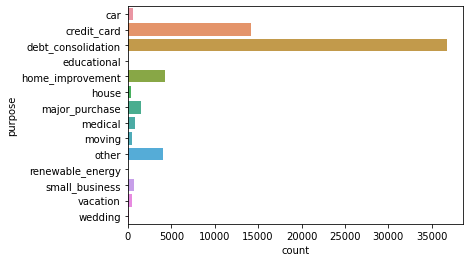

<AxesSubplot:xlabel='count', ylabel='emp_length'>

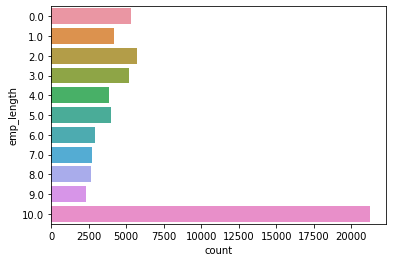

In [68]:
sns.countplot(y='purpose', data=df)
plt.show()
sns.countplot(y='emp_length', data=df)

In [69]:
#top_titles = (df.title.value_counts()[:10]).index
#tempdf = df[df.title.isin(list(top_titles))]
#sns.countplot(y='title', data=tempdf)

In [70]:
display(df.loc[df.target==1,'delinq_2yrs'].describe())
display(df.loc[df.target==0,'delinq_2yrs'].describe())
# i am not sure how this variable is defined. Is it at the moment of loan origination?

count    13001.000000
mean         0.344743
std          0.924157
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         16.000000
Name: delinq_2yrs, dtype: float64

count    51200.000000
mean         0.306387
std          0.853227
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         24.000000
Name: delinq_2yrs, dtype: float64

ValueError: cannot reindex from a duplicate axis

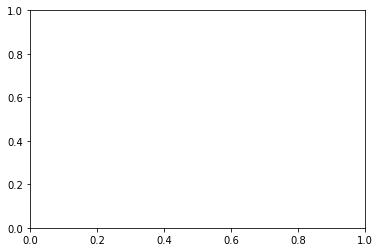

In [71]:
sns.histplot(x='int_rate', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='lti', data=df).set(title='Loan LTI')
plt.show()
sns.histplot(x='iti', data=df).set(title='Loan ITI')
plt.show()
sns.histplot(x='annual_inc', data=df, log_scale=True).set(title='Annual Income')
plt.show()

In [ ]:
sns.histplot(x='grade', data=df).set(title='Loan Grade')

### EDA with target

In [ ]:
sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x='grade', y='target', data=df)
plt.show()
sns.barplot(x='sub_grade', y='target', data=df)
plt.show()
sns.barplot(x='home_ownership', y='target', data=df)
plt.show()
sns.barplot(x='delinq_2yrs', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec', y='target', data=df)
plt.show()
sns.barplot(x='pub_rec_bankruptcies', y='target', data=df)
plt.show()
sns.set(rc={'figure.figsize':(20,8)})
sns.barplot(x='open_acc', y='target', data=df)
plt.show()
sns.barplot(x='total_acc', y='target', data=df)
plt.show()
sns.barplot(x='fico_range_high', y='target', data=df)
plt.show()
sns.barplot(x='purpose', y='target', data=df)
plt.show()

### Train-test split, missing values

In [ ]:
display(df.count())

In [129]:
features_fill_M = ['emp_title', 'title']
features_fill_med = ['dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc', 'mort_acc', 'pub_rec_bankruptcies']

df['emp_length'] = df['emp_length'].fillna(value=0)

for col in features_fill_M:
    df[col] = df[col].cat.add_categories(['MISSING']) 
    df[col] = df[col].fillna(value='MISSING')

test_size = 0.1
df.reset_index(inplace=True, drop=True)
test_index = random.sample(list(df.index), int(test_size*df.shape[0]))
train = df.iloc[list(set(df.index)-set(test_index))]
test = df.iloc[test_index]
display(train.shape, test.shape, train.head(3), test.head(3))

for col in features_fill_med:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())

display(train.count(), test.count())

(115941, 44)

(12882, 44)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt
0,12000,12000,12000.0,36,10.49,389.980011,B,B2,Captain,4.0,MORTGAGE,100000.0,Not Verified,car,Car financing,330,FL,6.200000,0.0,669,0.0,4.0,0.0,3019,24.0,8.0,w,Individual,0.0,0.0,2016,11,2016,10.749023,0.0,1.0,0.120000,0.046798,0,0.030190,0,0.500000,0,0
1,7500,7500,7500.0,36,10.99,245.509995,B,B4,Associate Dentist,0.0,RENT,100000.0,Verified,other,Other,605,IL,22.750000,2.0,669,3.0,28.0,0.0,12088,36.4,44.0,w,Individual,0.0,0.0,2015,10,2015,10.080974,0.0,0.0,0.075000,0.029461,0,0.120880,0,0.636364,0,0
2,22400,22400,22400.0,60,21.99,618.539978,E,E5,a&p mechanic,10.0,MORTGAGE,109000.0,Source Verified,home_improvement,Home improvement,743,OK,23.209999,0.0,729,3.0,18.0,0.0,11356,41.1,52.0,f,Individual,1.0,0.0,2015,2,2015,17.251552,0.0,0.0,0.205505,0.068096,0,0.104183,0,0.346154,0,0


,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,purpose,title,zip_code,addr_state,dti,delinq_2yrs,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,year_issued,month_issued,year_earliest,years_borrowing,pub_rec_pa,target,lti,iti,joint,revol_balance_income,low_fico,open_cl_ratio,hobo,was_bankrupt
11539,7875,7875,7875.0,36,13.99,269.119995,C,C4,Teacher,6.0,MORTGAGE,50000.0,Source Verified,debt_consolidation,Debt consolidation,370,TN,35.48,4.0,664,0.0,8.0,0.0,2761,64.2,44.0,f,Individual,3.0,0.0,2015,7,2015,16.000329,0.000000,0.0,0.157500,0.064589,0,0.055220,0,0.181818,0,0
20330,32000,32000,32000.0,60,23.99,920.390015,F,F2,Trooper,10.0,OWN,109000.0,Verified,debt_consolidation,Debt consolidation,186,PA,34.66,0.0,684,2.0,23.0,0.0,102382,69.0,70.0,f,Individual,2.0,0.0,2015,4,2015,20.750597,0.000000,1.0,0.293578,0.101327,0,0.939284,0,0.328571,0,0
22443,7850,7850,7850.0,36,13.35,265.829987,C,C2,custodian,8.0,RENT,28000.0,Not Verified,credit_card,Credit card refinancing,217,MD,13.29,0.0,674,1.0,6.0,1.0,8468,65.0,16.0,w,Individual,3.0,1.0,2014,10,2014,19.748523,0.050637,1.0,0.280357,0.113927,0,0.302429,0,0.375000,0,1


loan_amnt               115941
funded_amnt             115941
funded_amnt_inv         115941
term                    115941
int_rate                115941
installment             115941
grade                   115941
sub_grade               115941
emp_title               115941
emp_length              115941
home_ownership          115941
annual_inc              115941
verification_status     115941
purpose                 115941
title                   115941
zip_code                115941
addr_state              115941
dti                     115941
delinq_2yrs             115941
fico_range_high         115941
inq_last_6mths          115941
open_acc                115941
pub_rec                 115941
revol_bal               115941
revol_util              115941
total_acc               115941
initial_list_status     115941
application_type        115941
mort_acc                115941
pub_rec_bankruptcies    115941
year_issued             115941
month_issued            115941
year_ear

loan_amnt               12882
funded_amnt             12882
funded_amnt_inv         12882
term                    12882
int_rate                12882
installment             12882
grade                   12882
sub_grade               12882
emp_title               12882
emp_length              12882
home_ownership          12882
annual_inc              12882
verification_status     12882
purpose                 12882
title                   12882
zip_code                12882
addr_state              12882
dti                     12882
delinq_2yrs             12882
fico_range_high         12882
inq_last_6mths          12882
open_acc                12882
pub_rec                 12882
revol_bal               12882
revol_util              12882
total_acc               12882
initial_list_status     12882
application_type        12882
mort_acc                12882
pub_rec_bankruptcies    12882
year_issued             12882
month_issued            12882
year_earliest           12882
years_borr

### Categorical features encoding

In [72]:
# TE for categorical features

time1 = time.time()
encoder = CrossFoldEncoder(MEstimateEncoder, m=10)
train_encoded = encoder.fit_transform(train, train.target, cols=cat_features_te)
test_encoded = encoder.transform(test)

train.drop(columns=cat_features_te, inplace=True)
test.drop(columns=cat_features_te,  inplace=True)
train = pd.concat([train, train_encoded], axis = 1)
test = pd.concat([test, test_encoded], axis = 1)

display(time.time()-time0, time.time()-time1)
display(train.shape, train.head(), train.count())
train0 = train.copy()
test0 = test.copy()

NameError: name 'train' is not defined

In [73]:
X_train = train.copy()
y_train = X_train.pop('target')
X_test = test.copy()
y_test = X_test.pop('target')
display(X_test.head())

### Do OHE for some features ###

feature_transformer = ColumnTransformer([
    ("cat", OneHotEncoder(sparse = False, handle_unknown="ignore"), cat_features_ohe)], remainder="passthrough")

print('Number of features before transaformation: ', X_train.shape)
X_train = pd.DataFrame(feature_transformer.fit_transform(X_train), columns=feature_transformer.get_feature_names_out())
X_test = pd.DataFrame(feature_transformer.transform(X_test), columns=feature_transformer.get_feature_names_out())
print('time to do feature proprocessing: ', time.time()-time1)
print('Number of features after transaformation: ', X_train.shape)
X_train.head()

NameError: name 'train' is not defined

### Modeling

In [74]:
time1 = time.time()
xgb = XGBClassifier(tree_method = 'gpu_hist')
xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)

# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

NameError: name 'X_train' is not defined

In [75]:
### Fit XGBoost using Optuna hyperparameter optimization ###

def objective(trial, cv_runs=1, n_splits=2, n_jobs=-1, scale_pos_weight=1):

    cv_regularizer=0.05
    # Usually values between 0.1 and 0.2 work fine.

    params = {
        "tree_method": 'gpu_hist',
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "n_estimators": trial.suggest_int("n_estimators", 700, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.4),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.1, 0.95),
        "subsample": trial.suggest_uniform("subsample", 0.5, 0.95),
        "alpha": trial.suggest_loguniform("alpha", 0.1, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 0.1, 150.0),
        "gamma": trial.suggest_loguniform("gamma", 1e-10, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 0.1, 10),
        "n_jobs": n_jobs,
    }
    # usually it makes sense to resrtict hyperparameter space from some solutions which Optuna will find
    # e.g., for tmx-joined data only (downsampled tmx), optuna keeps selecting depths of 2 and 3.
    # for my purposes (smooth left side of prc, close to 1), those solutions are no good.

    temp_out = []

    for i in range(cv_runs):

        X = X_train
        y = y_train

        model = XGBClassifier(**params)
        rkf = KFold(n_splits=n_splits, shuffle=True)
        X_values = X.values
        y_values = y.values
        y_pred = np.zeros_like(y_values)
        y_pred_train = np.zeros_like(y_values)
        for train_index, test_index in rkf.split(X_values):
            X_A, X_B = X_values[train_index, :], X_values[test_index, :]
            y_A, y_B = y_values[train_index], y_values[test_index]
            model.fit(X_A, y_A, eval_set=[(X_B, y_B)], verbose = False)
            y_pred[test_index] += model.predict(X_B)
            y_pred_train[train_index] += model.predict(X_A)
        score_train = roc_auc_score(y_train, y_pred_train)
        score_test = roc_auc_score(y_train, y_pred) 
        overfit = score_train-score_test
        #return (score_test)
        #return (score_test-cv_regularizer*overfit)
        temp_out.append(score_test-cv_regularizer*overfit)

    return (np.mean(temp_out))

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print('Total time for hypermarameter optimization ', time.time()-time1)
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

optuna_hyperpars = study.best_params
optuna_hyperpars['tree_method']='gpu_hist'
optuna_hyperpars['scale_pos_weight']=1

optuna_xgb = XGBClassifier(**optuna_hyperpars)
optuna_xgb.fit(X_train, y_train)

precision_t, recall_t, threshold = precision_recall_curve(y_train, optuna_xgb.predict_proba(X_train)[:, 1])
auc_precision_recall_train = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_train = precision_t[indexx]
precision_t, recall_t, threshold = precision_recall_curve(y_test, optuna_xgb.predict_proba(X_test)[:, 1])
auc_precision_recall_test = auc(recall_t, precision_t)
temp = recall_t[(recall_t>0.195)&(recall_t<0.205)]
temp = temp[int(len(temp)/2)]
indexx = ((np.where(recall_t==temp)))[0][0]
r20prec_test = precision_t[indexx]

display('Train Accuracy: ', accuracy_score(y_train,optuna_xgb.predict(X_train)))
display('F1 score: ', f1_score(y_train,optuna_xgb.predict(X_train)))
display('ROCAUC: ', roc_auc_score(y_train,optuna_xgb.predict(X_train)))
display('PRAUC: ', auc_precision_recall_train)
display('R20P: ', r20prec_train)
# Performance evaluation:
display('Test Accuracy: ', accuracy_score(y_test,optuna_xgb.predict(X_test)))
display('F1 score: ', f1_score(y_test,optuna_xgb.predict(X_test)))
display('ROCAUC: ', roc_auc_score(y_test,optuna_xgb.predict(X_test)))
display('PRAUC: ', auc_precision_recall_test)
display('R20P: ', r20prec_test)
display(time.time()-time1)

[I 2022-08-12 15:55:18,794] A new study created in memory with name: no-name-ff1a77df-c0e9-495c-b605-bfffa6613c37
[W 2022-08-12 15:55:18,799] Trial 0 failed because of the following error: NameError("name 'X_train' is not defined")
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_16/2778900177.py", line 30, in objective
    X = X_train
NameError: name 'X_train' is not defined


NameError: name 'X_train' is not defined

In [134]:
results_fi = permutation_importance(optuna_xgb, X_test, y_test, n_jobs=-1)
fi = pd.DataFrame({'col':X_test.columns, 'FI':results_fi.importances_mean})
fi = fi.sort_values('FI', ascending = False)

display(fi[:30])

,col,FI
9,remainder__funded_amnt_inv,0.007250
8,remainder__funded_amnt,0.003881
32,remainder__iti,0.003819
21,remainder__revol_bal,0.003695
12,remainder__installment,0.003105
40,remainder__sub_grade_encoded,0.002919
42,remainder__home_ownership_encoded,0.002888
7,remainder__loan_amnt,0.002841
10,remainder__term,0.002189
28,remainder__year_earliest,0.002018


,col_name,feature_importance_vals
39,remainder__grade_encoded,0.203165
10,remainder__term,0.177201
17,remainder__fico_range_high,0.141239
31,remainder__lti,0.131590
8,remainder__funded_amnt,0.114646
11,remainder__int_rate,0.113445
28,remainder__year_earliest,0.107607
42,remainder__home_ownership_encoded,0.106341
21,remainder__revol_bal,0.105627
15,remainder__dti,0.102259


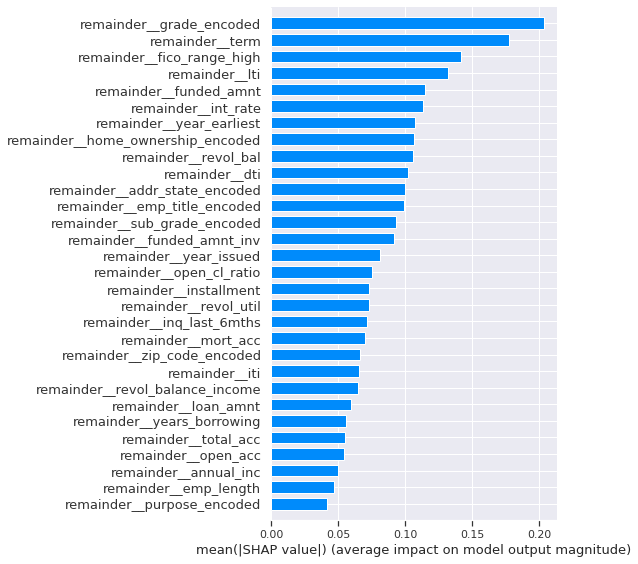

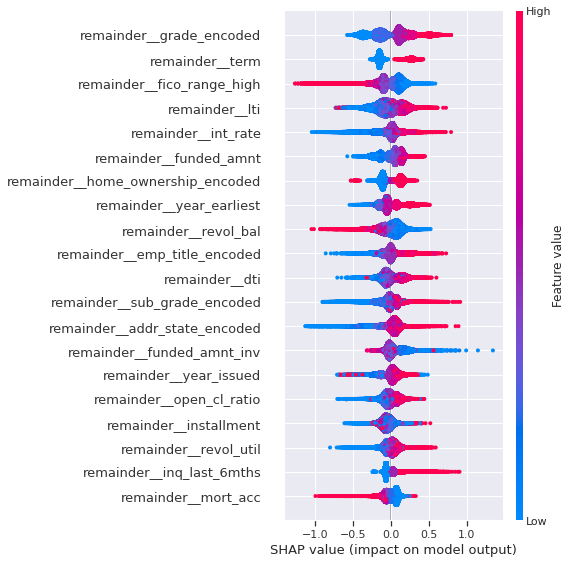

In [135]:
# template here: https://www.kaggle.com/code/kaanboke/catboost-lightgbm-xgboost-explained-by-shap/notebook
explainerxgbc = shap.TreeExplainer(optuna_xgb)
shap_values_XGBoost_test = explainerxgbc.shap_values(X_test)
shap_values_XGBoost_train = explainerxgbc.shap_values(X_train)

vals = np.abs(shap_values_XGBoost_test).mean(0)
feature_names = X_test.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                 columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                              ascending=False, inplace=True)
display(feature_importance[:30])

shap.summary_plot(shap_values_XGBoost_test, X_test, plot_type="bar", plot_size=(8,8), max_display=30)

shap.summary_plot(shap_values_XGBoost_train, X_train,plot_type="dot", plot_size=(8,8), max_display=20)

In [136]:
time.time()-time0

251.84657502174377